In [1]:
"""
    L100K-Net : A lightweight CNN Model With Less Than 100K Parameters for Plant Leaf Disease Classification
    Please download the dataset (Plant_leaf_diseases_dataset_without_augmentation.zip) from here https://data.mendeley.com/datasets/tywbtsjrjv/1
    and place it in the same directory as this notebook file
    For reproducing, please use the following : 
    Python version 3.9.16
    Keras version 2.10.0
    Tensorflow version 2.10.0
    Nvidia GPU With Compute Capability 7.0 or greater
"""
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import keras
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import *
from keras.models import Sequential, Model, load_model
from tensorflow.keras import mixed_precision
import keras.backend as K
import pandas as pd
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt
import splitfolders
import zipfile
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler
import shutil
import sys
from sklearn.metrics import classification_report, accuracy_score

In [2]:
print(sys.version)

3.9.16 (main, Jan 11 2023, 16:16:36) [MSC v.1916 64 bit (AMD64)]


In [3]:
tf. __version__

'2.10.0'

In [4]:
keras.__version__

'2.10.0'

In [5]:
# Limiting VRAM to only 512MB
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=512)])
  except RuntimeError as e:
    print(e)
    
# Enabling mixed precision
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660, compute capability 7.5


In [6]:
os.listdir()

['.ipynb_checkpoints',
 'L100K.ipynb',
 'Plant_leaf_diseases_dataset_without_augmentation.zip']

In [7]:
with zipfile.ZipFile('./Plant_leaf_diseases_dataset_without_augmentation.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [8]:
os.listdir('./Plant_leave_diseases_dataset_without_augmentation')

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Background_without_leaves',
 'Blueberry___healthy',
 'Cherry___healthy',
 'Cherry___Powdery_mildew',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___healthy',
 'Corn___Northern_Leaf_Blight',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___healthy',
 'Potato___Late_blight',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___healthy',
 'Strawberry___Leaf_scorch',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 '

In [9]:
shutil.rmtree('./Plant_leave_diseases_dataset_without_augmentation/Background_without_leaves')

In [10]:
# 80% Train 10% Val 10% Test
splitfolders.ratio("./Plant_leave_diseases_dataset_without_augmentation", output="split",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) # default values

Copying files: 54305 files [03:37, 249.83 files/s]


In [11]:
epochs = 30 # Total epochs to run
hw = 256 # Height/Width of images
batch_size = 16

In [12]:
from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './split/train/',
        target_size=(hw, hw),
        class_mode='sparse',
        shuffle=True,
        batch_size=batch_size
)

val_generator = val_datagen.flow_from_directory(
        './split/val/',
        target_size=(hw, hw),
        class_mode='sparse',
        batch_size=batch_size
)


test_generator = test_datagen.flow_from_directory(
        './split/test/',
        target_size=(hw, hw),
        class_mode='sparse',
        batch_size=batch_size,
        shuffle=False
)


Found 43429 images belonging to 38 classes.
Found 5417 images belonging to 38 classes.
Found 5459 images belonging to 38 classes.


In [13]:
def conv_block(x, f, k):
    conv = Conv2D(f, k, strides=1, padding='same')(x)
    conv = BatchNormalization()(conv)
    conv = Activation('swish')(conv)
    return conv


def squeeze_excite_block(tensor):
    # Codes used from : https://github.com/titu1994/keras-squeeze-excite-network
    init = tensor
    filters = init.shape[-1]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // 2, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)


    x = multiply([init, se])
    return x

def fused_mbconv(x, f=8):
    conv = conv_block(x, f, 3)
    conv = squeeze_excite_block(conv)
    identity = conv_block(x, f, 1)
    return Add()([conv, identity])

def dw_conv(x, k=3):
    conv = DepthwiseConv2D(k, strides=1, padding='same')(x)
    conv = BatchNormalization()(conv)
    conv = Activation('swish')(conv)
    return conv


def inverted_residual_block(x, squeeze, expand):
    conv = Conv2D(expand, 1, strides=1, padding='same')(x)
    conv = BatchNormalization()(conv)
    conv = Activation('swish')(conv)
    
    conv = DepthwiseConv2D(3, strides=1, padding='same')(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('swish')(conv)
    
    conv = Conv2D(squeeze, 1, strides=1, padding='same')(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('swish')(conv)
    
    return Add()([conv, x])


def get_output(x, output_name):
   
    squeeze = 6
    expand = 12
    
    conv = inverted_residual_block(x, squeeze, expand)
    conv = inverted_residual_block(conv, squeeze, expand)
    conv = MaxPooling2D(pool_size=(2))(conv)
    
    conv = conv_block(conv, squeeze*2, 1)
    
    conv = inverted_residual_block(conv, squeeze*2, expand*3)
    conv = inverted_residual_block(conv, squeeze*2, expand*3)
    conv = inverted_residual_block(conv, squeeze*2, expand*3)
    conv = MaxPooling2D(pool_size=(2))(conv)
    
    conv = conv_block(conv, squeeze*2, 1)
    
    conv = inverted_residual_block(conv, squeeze*2, expand*4)
    conv = inverted_residual_block(conv, squeeze*2, expand*4)
    conv = inverted_residual_block(conv, squeeze*2, expand*4)
    conv = inverted_residual_block(conv, squeeze*2, expand*4)
    
    
    conv = conv_block(conv, expand*6, 1)
    
    f1 = GlobalAveragePooling2D()(conv)
    
    d1 = Dense(38, activation='softmax', name=output_name)(f1)
    
    return d1


def L100K_NET():

    f = 6
    x = Input(shape=(hw,hw,3,))
    
    
    init = x
    conv = Conv2D(f, 7, strides=2, padding='same')(init)
    conv = Activation('swish')(conv)
    
    conv = MaxPooling2D(2)(conv)
    
    conv_1 = fused_mbconv(conv, f=f)
    op1 = get_output(conv_1, 'output_1')
    
    conv_2 = fused_mbconv(conv_1, f=f)
    op2 = get_output(conv_2, 'output_2')
    
    conv_3 = fused_mbconv(concatenate([conv_1, conv_2]), f=f)
    op3 = get_output(conv_3, 'output_3')
    
    conv_4 = fused_mbconv(concatenate([conv_1, conv_2, conv_3]), f=f)
    op4 = get_output(conv_4, 'output_4')
    
    conv_5 = fused_mbconv(concatenate([conv_1, conv_2, conv_3, conv_4]), f=f)
    op5 = get_output(conv_5, 'output_5')

    

    model = Model(inputs=x, outputs=[op1, op2, op3, op4, op5])
    
    return model

model = L100K_NET()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 6)  888         ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 128, 128, 6)  0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 6)    0           ['activation[0][0]']         

 obalAveragePooling2D)                                                                            
                                                                                                  
 reshape_2 (Reshape)            (None, 1, 1, 6)      0           ['global_average_pooling2d_4[0][0
                                                                 ]']                              
                                                                                                  
 dense_4 (Dense)                (None, 1, 1, 3)      21          ['reshape_2[0][0]']              
                                                                                                  
 conv2d_48 (Conv2D)             (None, 64, 64, 6)    78          ['concatenate[0][0]']            
                                                                                                  
 dense_5 (Dense)                (None, 1, 1, 6)      24          ['dense_4[0][0]']                
          

 multiply_4 (Multiply)          (None, 64, 64, 6)    0           ['activation_129[0][0]',         
                                                                  'dense_9[0][0]']                
                                                                                                  
 activation_130 (Activation)    (None, 64, 64, 6)    0           ['batch_normalization_129[0][0]']
                                                                                                  
 add_40 (Add)                   (None, 64, 64, 6)    0           ['multiply_4[0][0]',             
                                                                  'activation_130[0][0]']         
                                                                                                  
 conv2d_3 (Conv2D)              (None, 64, 64, 12)   84          ['add[0][0]']                    
                                                                                                  
 conv2d_26

 conv2d_4 (Conv2D)              (None, 64, 64, 6)    78          ['activation_4[0][0]']           
                                                                                                  
 conv2d_27 (Conv2D)             (None, 64, 64, 6)    78          ['activation_36[0][0]']          
                                                                                                  
 conv2d_50 (Conv2D)             (None, 64, 64, 6)    78          ['activation_68[0][0]']          
                                                                                                  
 conv2d_73 (Conv2D)             (None, 64, 64, 6)    78          ['activation_100[0][0]']         
                                                                                                  
 conv2d_96 (Conv2D)             (None, 64, 64, 6)    78          ['activation_132[0][0]']         
                                                                                                  
 batch_nor

 activation_134 (Activation)    (None, 64, 64, 12)   0           ['batch_normalization_133[0][0]']
                                                                                                  
 depthwise_conv2d_1 (DepthwiseC  (None, 64, 64, 12)  120         ['activation_6[0][0]']           
 onv2D)                                                                                           
                                                                                                  
 depthwise_conv2d_10 (Depthwise  (None, 64, 64, 12)  120         ['activation_38[0][0]']          
 Conv2D)                                                                                          
                                                                                                  
 depthwise_conv2d_19 (Depthwise  (None, 64, 64, 12)  120         ['activation_70[0][0]']          
 Conv2D)                                                                                          
          

 add_22 (Add)                   (None, 64, 64, 6)    0           ['activation_72[0][0]',          
                                                                  'add_21[0][0]']                 
                                                                                                  
 add_32 (Add)                   (None, 64, 64, 6)    0           ['activation_104[0][0]',         
                                                                  'add_31[0][0]']                 
                                                                                                  
 add_42 (Add)                   (None, 64, 64, 6)    0           ['activation_136[0][0]',         
                                                                  'add_41[0][0]']                 
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 6)   0           ['add_2[0][0]']                  
          

 activation_74 (Activation)     (None, 32, 32, 36)   0           ['batch_normalization_73[0][0]'] 
                                                                                                  
 activation_106 (Activation)    (None, 32, 32, 36)   0           ['batch_normalization_105[0][0]']
                                                                                                  
 activation_138 (Activation)    (None, 32, 32, 36)   0           ['batch_normalization_137[0][0]']
                                                                                                  
 depthwise_conv2d_2 (DepthwiseC  (None, 32, 32, 36)  360         ['activation_10[0][0]']          
 onv2D)                                                                                           
                                                                                                  
 depthwise_conv2d_11 (Depthwise  (None, 32, 32, 36)  360         ['activation_42[0][0]']          
 Conv2D)  

                                                                                                  
 add_13 (Add)                   (None, 32, 32, 12)   0           ['activation_44[0][0]',          
                                                                  'activation_41[0][0]']          
                                                                                                  
 add_23 (Add)                   (None, 32, 32, 12)   0           ['activation_76[0][0]',          
                                                                  'activation_73[0][0]']          
                                                                                                  
 add_33 (Add)                   (None, 32, 32, 12)   0           ['activation_108[0][0]',         
                                                                  'activation_105[0][0]']         
                                                                                                  
 add_43 (A

                                                                                                  
 activation_110 (Activation)    (None, 32, 32, 36)   0           ['batch_normalization_109[0][0]']
                                                                                                  
 activation_142 (Activation)    (None, 32, 32, 36)   0           ['batch_normalization_141[0][0]']
                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 32, 12)   444         ['activation_14[0][0]']          
                                                                                                  
 conv2d_34 (Conv2D)             (None, 32, 32, 12)   444         ['activation_46[0][0]']          
                                                                                                  
 conv2d_57 (Conv2D)             (None, 32, 32, 12)   444         ['activation_78[0][0]']          
          

                                                                                                  
 activation_80 (Activation)     (None, 32, 32, 36)   0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_112 (Activation)    (None, 32, 32, 36)   0           ['batch_normalization_111[0][0]']
                                                                                                  
 activation_144 (Activation)    (None, 32, 32, 36)   0           ['batch_normalization_143[0][0]']
                                                                                                  
 depthwise_conv2d_4 (DepthwiseC  (None, 32, 32, 36)  360         ['activation_16[0][0]']          
 onv2D)                                                                                           
                                                                                                  
 depthwise

                                                                  'add_4[0][0]']                  
                                                                                                  
 add_15 (Add)                   (None, 32, 32, 12)   0           ['activation_50[0][0]',          
                                                                  'add_14[0][0]']                 
                                                                                                  
 add_25 (Add)                   (None, 32, 32, 12)   0           ['activation_82[0][0]',          
                                                                  'add_24[0][0]']                 
                                                                                                  
 add_35 (Add)                   (None, 32, 32, 12)   0           ['activation_114[0][0]',         
                                                                  'add_34[0][0]']                 
          

 Normalization)                                                                                   
                                                                                                  
 activation_20 (Activation)     (None, 16, 16, 48)   0           ['batch_normalization_19[0][0]'] 
                                                                                                  
 activation_52 (Activation)     (None, 16, 16, 48)   0           ['batch_normalization_51[0][0]'] 
                                                                                                  
 activation_84 (Activation)     (None, 16, 16, 48)   0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 activation_116 (Activation)    (None, 16, 16, 48)   0           ['batch_normalization_115[0][0]']
                                                                                                  
 activatio

 activation_118 (Activation)    (None, 16, 16, 12)   0           ['batch_normalization_117[0][0]']
                                                                                                  
 activation_150 (Activation)    (None, 16, 16, 12)   0           ['batch_normalization_149[0][0]']
                                                                                                  
 add_6 (Add)                    (None, 16, 16, 12)   0           ['activation_22[0][0]',          
                                                                  'activation_19[0][0]']          
                                                                                                  
 add_16 (Add)                   (None, 16, 16, 12)   0           ['activation_54[0][0]',          
                                                                  'activation_51[0][0]']          
                                                                                                  
 add_26 (A

                                                                                                  
 activation_24 (Activation)     (None, 16, 16, 48)   0           ['batch_normalization_23[0][0]'] 
                                                                                                  
 activation_56 (Activation)     (None, 16, 16, 48)   0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 activation_88 (Activation)     (None, 16, 16, 48)   0           ['batch_normalization_87[0][0]'] 
                                                                                                  
 activation_120 (Activation)    (None, 16, 16, 48)   0           ['batch_normalization_119[0][0]']
                                                                                                  
 activation_152 (Activation)    (None, 16, 16, 48)   0           ['batch_normalization_151[0][0]']
          

 batch_normalization_153 (Batch  (None, 16, 16, 48)  192         ['conv2d_111[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_26 (Activation)     (None, 16, 16, 48)   0           ['batch_normalization_25[0][0]'] 
                                                                                                  
 activation_58 (Activation)     (None, 16, 16, 48)   0           ['batch_normalization_57[0][0]'] 
                                                                                                  
 activation_90 (Activation)     (None, 16, 16, 48)   0           ['batch_normalization_89[0][0]'] 
                                                                                                  
 activation_122 (Activation)    (None, 16, 16, 48)   0           ['batch_normalization_121[0][0]']
          

                                                                                                  
 activation_124 (Activation)    (None, 16, 16, 12)   0           ['batch_normalization_123[0][0]']
                                                                                                  
 activation_156 (Activation)    (None, 16, 16, 12)   0           ['batch_normalization_155[0][0]']
                                                                                                  
 add_8 (Add)                    (None, 16, 16, 12)   0           ['activation_28[0][0]',          
                                                                  'add_7[0][0]']                  
                                                                                                  
 add_18 (Add)                   (None, 16, 16, 12)   0           ['activation_60[0][0]',          
                                                                  'add_17[0][0]']                 
          

 Normalization)                                                                                   
                                                                                                  
 activation_30 (Activation)     (None, 16, 16, 48)   0           ['batch_normalization_29[0][0]'] 
                                                                                                  
 activation_62 (Activation)     (None, 16, 16, 48)   0           ['batch_normalization_61[0][0]'] 
                                                                                                  
 activation_94 (Activation)     (None, 16, 16, 48)   0           ['batch_normalization_93[0][0]'] 
                                                                                                  
 activation_126 (Activation)    (None, 16, 16, 48)   0           ['batch_normalization_125[0][0]']
                                                                                                  
 activatio

                                                                                                  
 batch_normalization_159 (Batch  (None, 16, 16, 72)  288         ['conv2d_115[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_32 (Activation)     (None, 16, 16, 72)   0           ['batch_normalization_31[0][0]'] 
                                                                                                  
 activation_64 (Activation)     (None, 16, 16, 72)   0           ['batch_normalization_63[0][0]'] 
                                                                                                  
 activation_96 (Activation)     (None, 16, 16, 72)   0           ['batch_normalization_95[0][0]'] 
                                                                                                  
 activatio

In [14]:
media_start = './'
optimizer = Adam(0.01)

model_path = media_start+"L100K.hdf5"

checkpoint = ModelCheckpoint(model_path, save_freq="epoch",save_best_only=True,
    save_weights_only=False, monitor='val_loss', verbose=1)

csv_logger = CSVLogger(media_start+"log.csv")

ce = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="auto", name="sparse_categorical_crossentropy"
)

def scheduler(epoch):
    initial = 0.01
    lr = initial
    if epoch >= 10:
        lr = 0.001
    if epoch >= 20:
        lr = 0.0001        
    return lr


scheduler_callback = LearningRateScheduler(scheduler, verbose=1)

model.compile(optimizer = optimizer, loss=ce, metrics = ['accuracy'])

train_steps = train_generator.n//batch_size
val_steps = val_generator.n//batch_size


history = model.fit(train_generator,
        steps_per_epoch=train_steps,
        epochs=epochs,
        verbose=1,
        validation_data=val_generator,
        validation_steps=val_steps,
        callbacks=[checkpoint, csv_logger, scheduler_callback]
)

# Loading the best saved model weights
model.load_weights(model_path)
pred = model.predict(test_generator)
pred = np.array(pred)


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/30
2714/2714 [==============================] - ETA: 0s - loss: 7.0389 - output_1_loss: 1.3915 - output_2_loss: 1.4183 - output_3_loss: 1.3769 - output_4_loss: 1.3925 - output_5_loss: 1.4597 - output_1_accuracy: 0.5927 - output_2_accuracy: 0.5875 - output_3_accuracy: 0.5925 - output_4_accuracy: 0.5900 - output_5_accuracy: 0.5740
Epoch 1: val_loss improved from inf to 5.41386, saving model to .\L100K.hdf5
2714/2714 [==============================] - 917s 321ms/step - loss: 7.0389 - output_1_loss: 1.3915 - output_2_loss: 1.4183 - output_3_loss: 1.3769 - output_4_loss: 1.3925 - output_5_loss: 1.4597 - output_1_accuracy: 0.5927 - output_2_accuracy: 0.5875 - output_3_accuracy: 0.5925 - output_4_accuracy: 0.5900 - output_5_accuracy: 0.5740 - val_loss: 5.4139 - val_output_1_loss: 0.9332 - val_output_2_loss: 1.0539 - val_output_3_loss: 1.1788 - val_output_4_loss: 0.9986 - val_output_5_loss: 1.2492 - val_output_1_accuracy: 0

2714/2714 [==============================] - ETA: 0s - loss: 1.1785 - output_1_loss: 0.2488 - output_2_loss: 0.2474 - output_3_loss: 0.2329 - output_4_loss: 0.2234 - output_5_loss: 0.2259 - output_1_accuracy: 0.9187 - output_2_accuracy: 0.9195 - output_3_accuracy: 0.9251 - output_4_accuracy: 0.9278 - output_5_accuracy: 0.9262
Epoch 8: val_loss did not improve from 1.99540
2714/2714 [==============================] - 865s 319ms/step - loss: 1.1785 - output_1_loss: 0.2488 - output_2_loss: 0.2474 - output_3_loss: 0.2329 - output_4_loss: 0.2234 - output_5_loss: 0.2259 - output_1_accuracy: 0.9187 - output_2_accuracy: 0.9195 - output_3_accuracy: 0.9251 - output_4_accuracy: 0.9278 - output_5_accuracy: 0.9262 - val_loss: 6.6962 - val_output_1_loss: 1.0499 - val_output_2_loss: 1.3535 - val_output_3_loss: 1.4563 - val_output_4_loss: 1.6068 - val_output_5_loss: 1.2298 - val_output_1_accuracy: 0.7396 - val_output_2_accuracy: 0.6727 - val_output_3_accuracy: 0.6575 - val_output_4_accuracy: 0.6574 - 

2714/2714 [==============================] - ETA: 0s - loss: 0.5009 - output_1_loss: 0.1090 - output_2_loss: 0.1104 - output_3_loss: 0.0976 - output_4_loss: 0.0919 - output_5_loss: 0.0920 - output_1_accuracy: 0.9657 - output_2_accuracy: 0.9652 - output_3_accuracy: 0.9689 - output_4_accuracy: 0.9702 - output_5_accuracy: 0.9709
Epoch 15: val_loss did not improve from 0.36126
2714/2714 [==============================] - 812s 299ms/step - loss: 0.5009 - output_1_loss: 0.1090 - output_2_loss: 0.1104 - output_3_loss: 0.0976 - output_4_loss: 0.0919 - output_5_loss: 0.0920 - output_1_accuracy: 0.9657 - output_2_accuracy: 0.9652 - output_3_accuracy: 0.9689 - output_4_accuracy: 0.9702 - output_5_accuracy: 0.9709 - val_loss: 0.4350 - val_output_1_loss: 0.1101 - val_output_2_loss: 0.0984 - val_output_3_loss: 0.0747 - val_output_4_loss: 0.0836 - val_output_5_loss: 0.0682 - val_output_1_accuracy: 0.9806 - val_output_2_accuracy: 0.9808 - val_output_3_accuracy: 0.9854 - val_output_4_accuracy: 0.9835 -

2714/2714 [==============================] - ETA: 0s - loss: 0.4010 - output_1_loss: 0.0879 - output_2_loss: 0.0878 - output_3_loss: 0.0763 - output_4_loss: 0.0745 - output_5_loss: 0.0745 - output_1_accuracy: 0.9719 - output_2_accuracy: 0.9721 - output_3_accuracy: 0.9755 - output_4_accuracy: 0.9759 - output_5_accuracy: 0.9755
Epoch 22: val_loss improved from 0.34711 to 0.33898, saving model to .\L100K.hdf5
2714/2714 [==============================] - 853s 314ms/step - loss: 0.4010 - output_1_loss: 0.0879 - output_2_loss: 0.0878 - output_3_loss: 0.0763 - output_4_loss: 0.0745 - output_5_loss: 0.0745 - output_1_accuracy: 0.9719 - output_2_accuracy: 0.9721 - output_3_accuracy: 0.9755 - output_4_accuracy: 0.9759 - output_5_accuracy: 0.9755 - val_loss: 0.3390 - val_output_1_loss: 0.0846 - val_output_2_loss: 0.0751 - val_output_3_loss: 0.0627 - val_output_4_loss: 0.0665 - val_output_5_loss: 0.0502 - val_output_1_accuracy: 0.9895 - val_output_2_accuracy: 0.9884 - val_output_3_accuracy: 0.9891

2714/2714 [==============================] - ETA: 0s - loss: 0.3910 - output_1_loss: 0.0863 - output_2_loss: 0.0850 - output_3_loss: 0.0769 - output_4_loss: 0.0712 - output_5_loss: 0.0715 - output_1_accuracy: 0.9711 - output_2_accuracy: 0.9725 - output_3_accuracy: 0.9744 - output_4_accuracy: 0.9763 - output_5_accuracy: 0.9765
Epoch 29: val_loss did not improve from 0.33549
2714/2714 [==============================] - 738s 272ms/step - loss: 0.3910 - output_1_loss: 0.0863 - output_2_loss: 0.0850 - output_3_loss: 0.0769 - output_4_loss: 0.0712 - output_5_loss: 0.0715 - output_1_accuracy: 0.9711 - output_2_accuracy: 0.9725 - output_3_accuracy: 0.9744 - output_4_accuracy: 0.9763 - output_5_accuracy: 0.9765 - val_loss: 0.3393 - val_output_1_loss: 0.0874 - val_output_2_loss: 0.0744 - val_output_3_loss: 0.0608 - val_output_4_loss: 0.0676 - val_output_5_loss: 0.0491 - val_output_1_accuracy: 0.9891 - val_output_2_accuracy: 0.9889 - val_output_3_accuracy: 0.9898 - val_output_4_accuracy: 0.9891 -

In [15]:
y_true = test_generator.labels

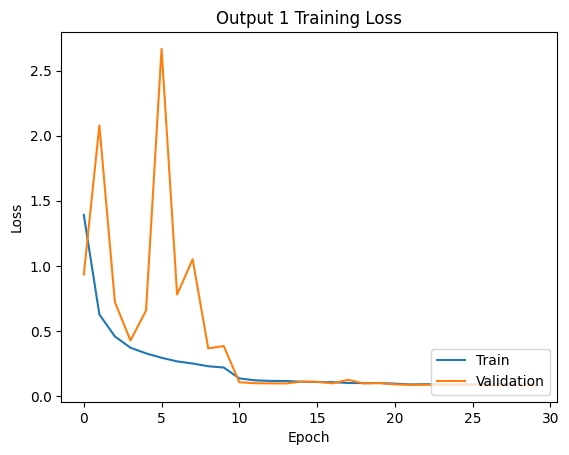

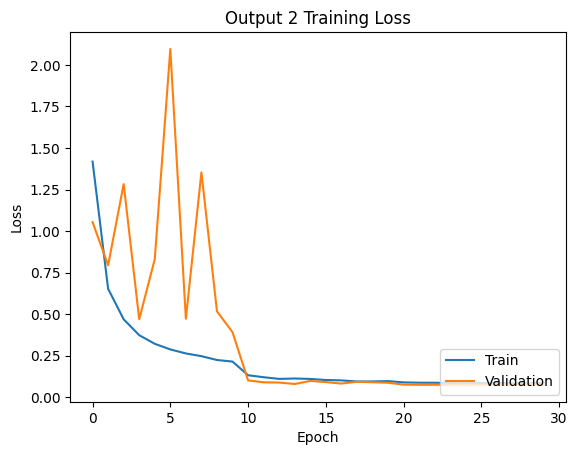

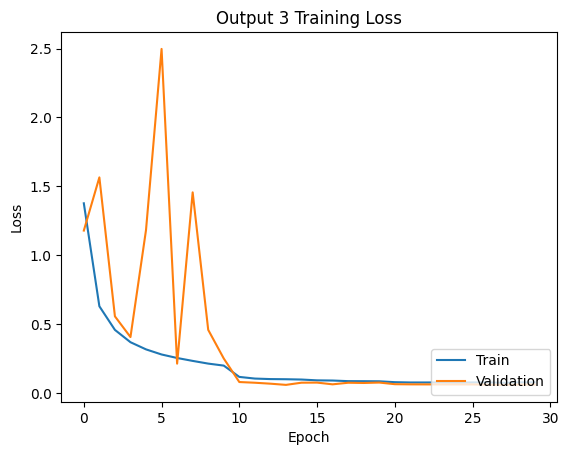

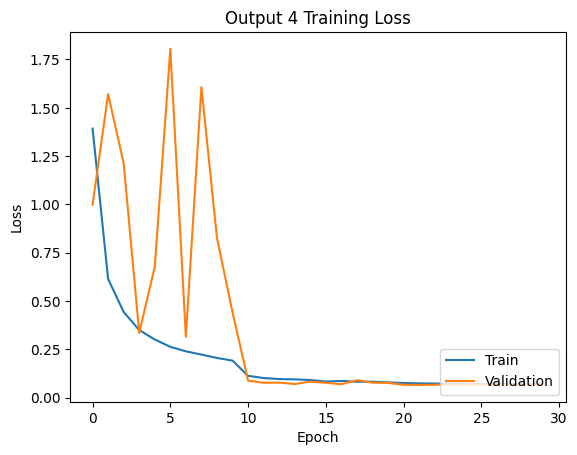

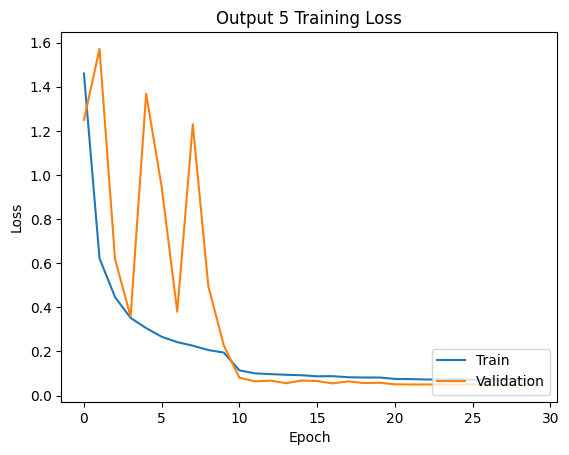

In [16]:
for i in range(1, 6):
    plt.plot(history.history['output_'+str(i)+'_loss'])
    plt.plot(history.history['val_output_'+str(i)+'_loss'])
    plt.title('Output '+str(i)+' Training Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()

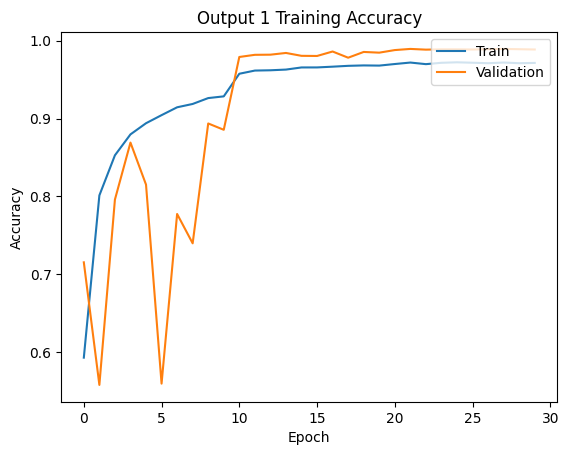

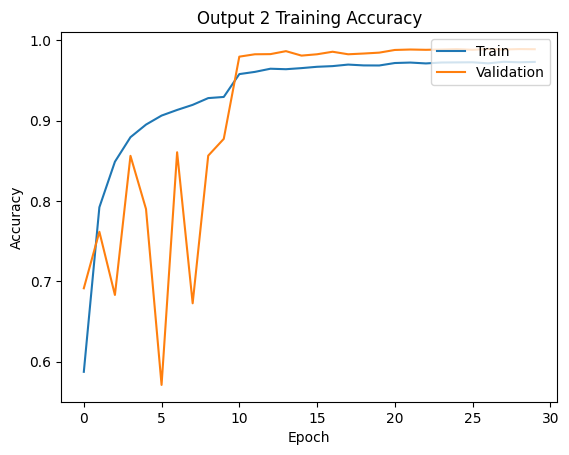

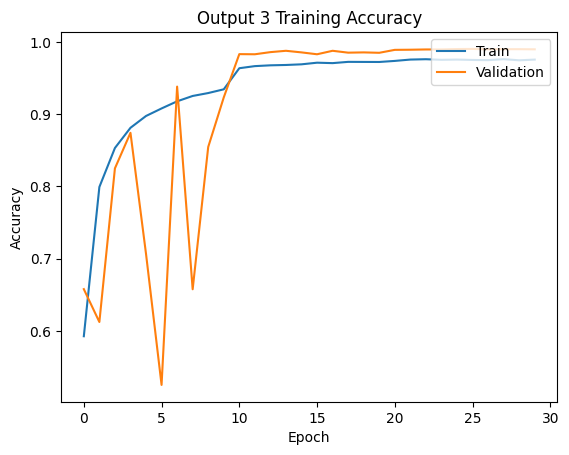

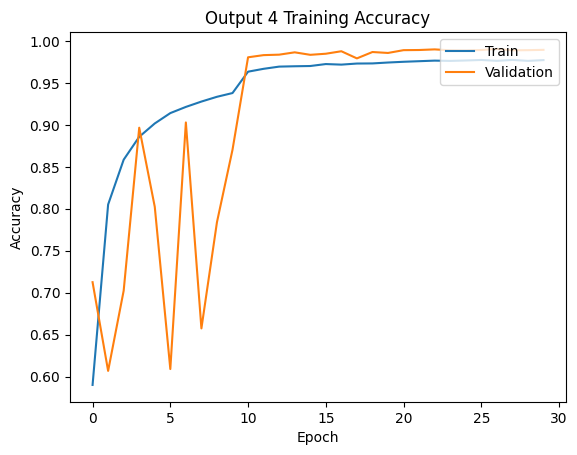

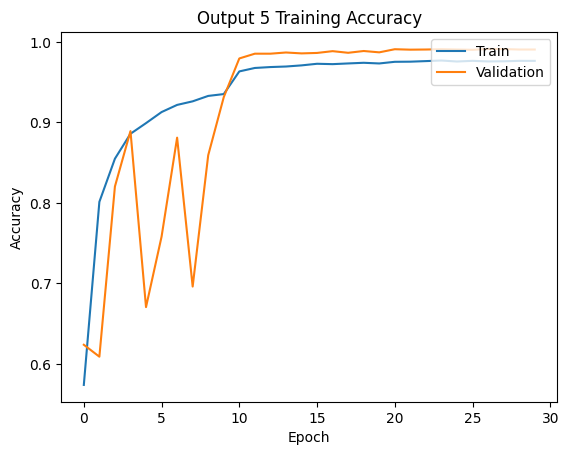

In [17]:
for i in range(1, 6):
    plt.plot(history.history['output_'+str(i)+'_accuracy'])
    plt.plot(history.history['val_output_'+str(i)+'_accuracy'])
    plt.title('Output '+str(i)+' Training Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

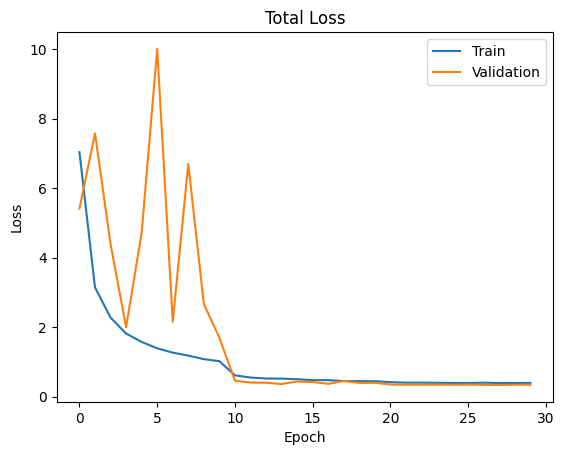

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Total Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

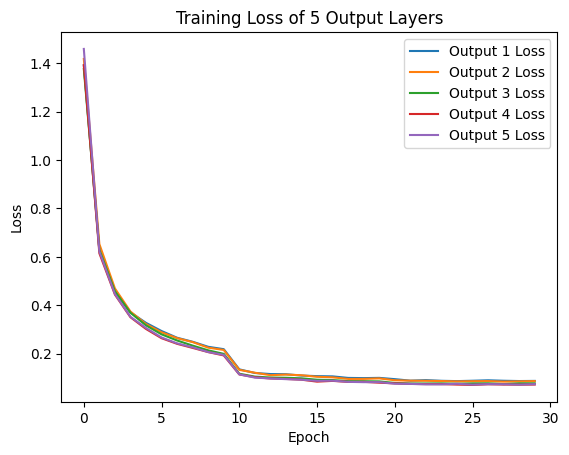

In [19]:
legends = []
for i in range(1, 6):
    plt.plot(history.history['output_'+str(i)+'_loss'])
    legends.append('Output '+str(i)+' Loss')
plt.title('Training Loss of 5 Output Layers')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(legends, loc='upper right')
plt.show()

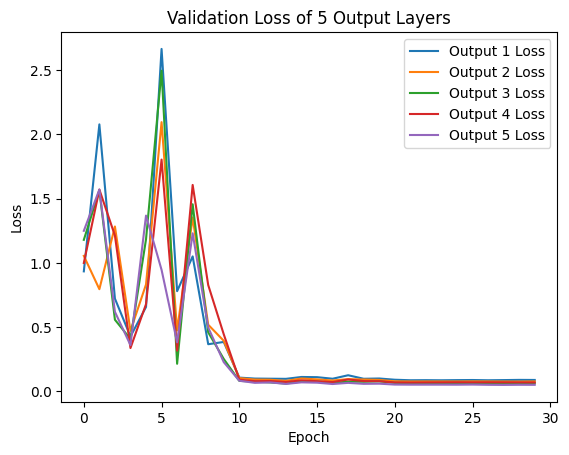

In [20]:
legends = []
for i in range(1, 6):
    plt.plot(history.history['val_output_'+str(i)+'_loss'])
    legends.append('Output '+str(i)+' Loss')
plt.title('Validation Loss of 5 Output Layers')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(legends, loc='upper right')
plt.show()

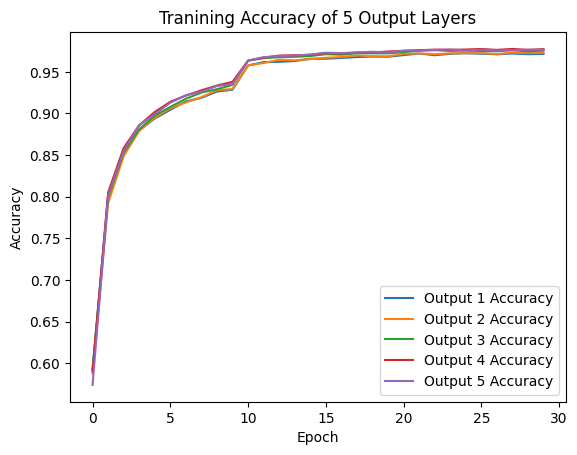

In [21]:
legends = []
for i in range(1, 6):
    plt.plot(history.history['output_'+str(i)+'_accuracy'])
    legends.append('Output '+str(i)+' Accuracy')
plt.title('Tranining Accuracy of 5 Output Layers')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(legends, loc='lower right')
plt.show()

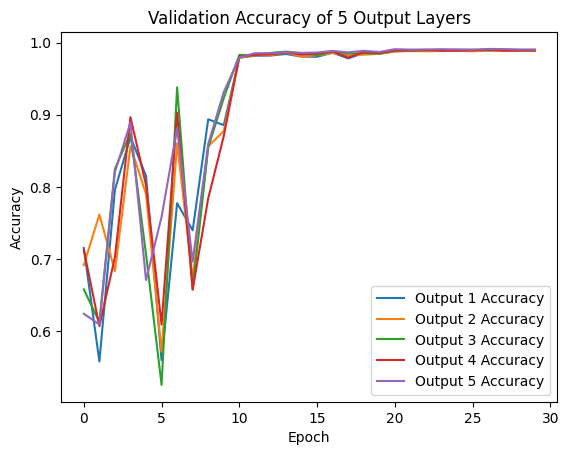

In [22]:
legends = []
for i in range(1, 6):
    plt.plot(history.history['val_output_'+str(i)+'_accuracy'])
    legends.append('Output '+str(i)+' Accuracy')
plt.title('Validation Accuracy of 5 Output Layers')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(legends, loc='lower right')
plt.show()

In [23]:
pred.shape

(5, 5459, 38)

In [24]:
for i in range(5):
    y_pred = np.argmax(pred[i, :, :], axis=-1)
    print("Accuracy score (Output layer "+str(i+1)+")  :", accuracy_score(y_true, y_pred))

Accuracy score (Output layer 1)  : 0.9853453013372413
Accuracy score (Output layer 2)  : 0.9869939549368016
Accuracy score (Output layer 3)  : 0.9891921597362154
Accuracy score (Output layer 4)  : 0.988642608536362
Accuracy score (Output layer 5)  : 0.9897417109360689


In [25]:
pred_avg = np.mean(pred, axis=0)
y_pred = np.argmax(pred_avg, axis=-1)
print("Accuracy score (Avreraged Predictions) :", accuracy_score(y_true, y_pred))

Accuracy score (Avreraged Predictions) : 0.9919399157354827


In [26]:
label_names = test_generator.class_indices.keys()
label_names

dict_keys(['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___

In [27]:
for i in range(5):
    y_pred = np.argmax(pred[i, :, :], axis=-1)
    print("Classification report for (Output layer "+str(i+1)+")  :")
    print(classification_report(y_true, y_pred, target_names=label_names))

Classification report for (Output layer 1)  :
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.98      0.98      0.98        63
                            Apple___Black_rot       1.00      0.98      0.99        63
                     Apple___Cedar_apple_rust       1.00      1.00      1.00        28
                              Apple___healthy       0.99      0.99      0.99       165
                          Blueberry___healthy       0.99      1.00      1.00       151
                      Cherry___Powdery_mildew       0.99      1.00      1.00       106
                             Cherry___healthy       0.98      1.00      0.99        86
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.91      0.92      0.91        52
                           Corn___Common_rust       1.00      1.00      1.00       120
                  Corn___Northern_Leaf_Blight       0.96      0.95      0.95       

In [28]:
pred_avg = np.mean(pred, axis=0)
y_pred = np.argmax(pred_avg, axis=-1)
print("Classification report for (Averaged Predictions)")
print(classification_report(y_true, y_pred, target_names=label_names))

Classification report for (Averaged Predictions)
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      1.00      1.00        63
                            Apple___Black_rot       0.98      0.98      0.98        63
                     Apple___Cedar_apple_rust       1.00      1.00      1.00        28
                              Apple___healthy       0.99      1.00      1.00       165
                          Blueberry___healthy       1.00      1.00      1.00       151
                      Cherry___Powdery_mildew       1.00      1.00      1.00       106
                             Cherry___healthy       0.97      1.00      0.98        86
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.96      0.94      0.95        52
                           Corn___Common_rust       1.00      1.00      1.00       120
                  Corn___Northern_Leaf_Blight       0.97      0.98      0.97    